<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/main/qbm_codes/mcmc_cl_and_quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:
!pip install qiskit ipywidgets # while working on google colab!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 19.2 MB 1.2 MB/s 
     |████████████████████████████████| 240 kB 72.1 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 64.5 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 37.5 MB 42 kB/s 
     |████████████████████████████████| 943 kB 43.5 MB/s 
     |████████████████████████████████| 4.0 MB 25.8 MB/s 
     |████████████████████████████████| 1.9 MB 43.5 MB/s 
     |████████████████████████████████| 112 kB 51.9 MB/s 
     |████████████████████████████████| 1.6 MB 52.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.0-py3-none-any.whl size=12188 sha256=b54b9de52784293bfa63eaf250e4edf0930572a00338db6979374c942f56c9fe
  St

In [3]:
# while working on google colab, run this cell
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils_2.py

--2022-10-25 14:03:36--  https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils_2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27243 (27K) [text/plain]
Saving to: ‘qbm_utils_2.py’

qbm_utils_2.py      100%[===================>]  26.60K  --.-KB/s    in 0.001s  

2022-10-25 14:03:36 (17.7 MB/s) - ‘qbm_utils_2.py’ saved [27243/27243]



In [4]:
from qbm_utils_2 import *

### Define the model

In [5]:
# define the model
np.random.seed(1)# should always be in the same cell!  
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.    -0.145 -0.35  -0.085  0.09  -1.245  0.93   0.04 ]
 [-0.145  0.     0.29  -1.37  -0.585 -0.635  0.875 -0.085]
 [-0.35   0.29   0.     0.23  -0.885  0.195  0.6    0.395]
 [-0.085 -1.37   0.23   0.    -0.14   1.11  -0.52   0.245]
 [ 0.09  -0.585 -0.885 -0.14   0.     0.14   0.26  -0.005]
 [-1.245 -0.635  0.195  1.11   0.14   0.    -0.08   1.675]
 [ 0.93   0.875  0.6   -0.52   0.26  -0.08   0.     0.55 ]
 [ 0.04  -0.085  0.395  0.245 -0.005  1.675  0.55   0.   ]]
h is: [ 0.49 -0.08  1.13  1.52  2.19 -1.4  -1.44 -0.5 ]
alpha:  0.5640831659646375


### Get the true distribution

In [6]:
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn=value_sorted_dict( dict(zip(states_nbit, prob_vals )), reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    #plot_histogram([boltz_prob_distn], legend=["analytical"], sort="value_desc")
    plot_bargraph_desc_order(boltz_prob_distn, label="analytical",plot_first_few=20); plt.legend()
    return boltz_prob_distn

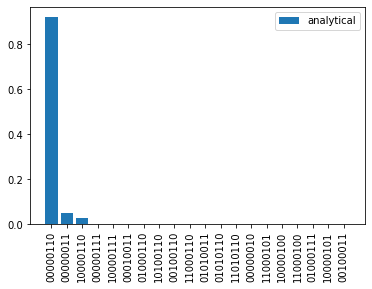

In [7]:
states_nbit=states(num_spins=n_spins)
temp=0.35
boltz_prob_distn=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)

In [8]:
mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  -3.9452232402199825


### Function to run different number of chains of mcmc for a particular problem instance

In [9]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc:{is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=cl_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=cl_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [10]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=600;num_seperate_mcmc_chains=8; return_last_n_states=N_hops
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

Whether running quantum mcmc:False


  0%|          | 0/8 [00:00<?, ?it/s]

starting with:  01000111



100%|██████████| 600/600 [00:00<00:00, 21628.67it/s]


starting with:  10110100



100%|██████████| 600/600 [00:00<00:00, 25073.55it/s]


starting with:  11110101



 38%|███▊      | 3/8 [00:00<00:00, 21.16it/s]

starting with:  00100001



100%|██████████| 600/600 [00:00<00:00, 26800.09it/s]


starting with:  11011110



100%|██████████| 600/600 [00:00<00:00, 30350.62it/s]


starting with:  10010111



 75%|███████▌  | 6/8 [00:00<00:00, 20.62it/s]

starting with:  01010110



100%|██████████| 600/600 [00:00<00:00, 28276.21it/s]


starting with:  00110100



100%|██████████| 8/8 [00:00<00:00, 19.93it/s]


100%|██████████| 599/599 [00:00<00:00, 810.62it/s]


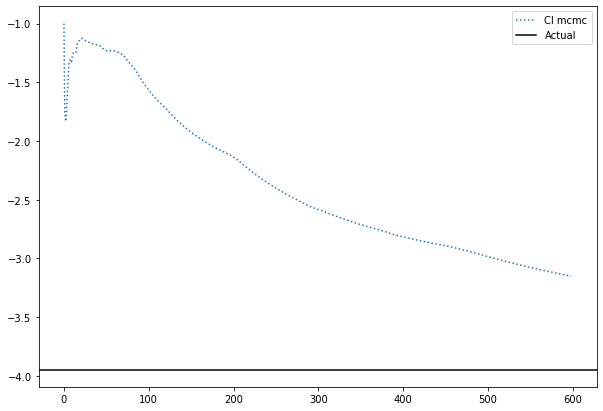

In [11]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops# 
#cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]
dict_for_df_running_avg_seperate_mcmc={}
for m in range(0, num_seperate_mcmc_chains):
  dict_for_df_running_avg_seperate_mcmc[m]=list(running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]).values())

running_avg_df=pd.DataFrame(dict_for_df_running_avg_seperate_mcmc)
mean_magnetization=running_avg_df.mean(axis=1)# mean taken over all seperate mcmc chains

plt.figure(figsize=(10,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.plot(mean_magnetization,":" ,label="Cl mcmc")
plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()

In [12]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))*(1./return_last_n_states))
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn


## KL DIVERGENCE
def kl_divergence(dict_prob_distn_data,dict_prob_distn_model):
    ''' Borrowed from an old notebook''' 
    list_prob_model=list(dict_prob_distn_data.values())
    list_prob_data=list(dict_prob_distn_model.values())
    
    to_return=0
    for i in range(0,len(list_prob_model)):
        if(list_prob_data[i]== 0):
            to_return+= 0
        if(list_prob_model[i]!= 0):
            to_return+=list_prob_data[i]*np.log(list_prob_model[i]/list_prob_data[i])
    to_return=(-1)*to_return
    
    return to_return

<Figure size 432x288 with 0 Axes>

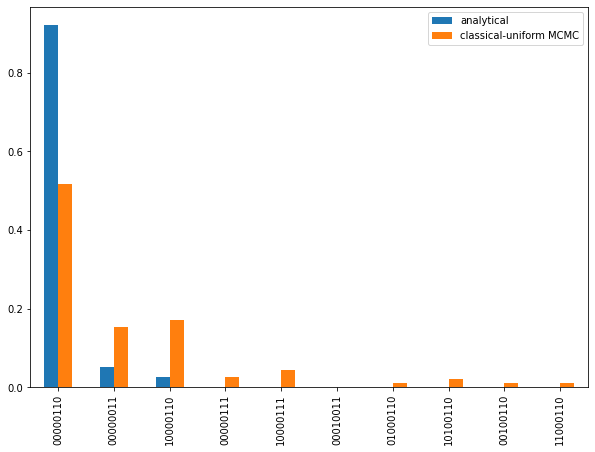

In [13]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=get_empirical_distn(dict_mean_occurences)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [14]:
kl_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn)

0.5250069654814651

### Quantum enhanced MCMC

In [15]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops=600;num_seperate_mcmc_chains=8; return_last_n_states=N_hops
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

Whether running quantum mcmc:True


  0%|          | 0/8 [00:00<?, ?it/s]

starting with:  11110010



 12%|█▎        | 1/8 [01:44<12:14, 104.91s/it]

starting with:  11100010



 25%|██▌       | 2/8 [03:20<09:57, 99.58s/it] 

starting with:  11011101



 38%|███▊      | 3/8 [04:55<08:07, 97.45s/it]

starting with:  10111110



 50%|█████     | 4/8 [06:30<06:26, 96.61s/it]

starting with:  11111110



 62%|██████▎   | 5/8 [08:10<04:52, 97.63s/it]

starting with:  01010000



 75%|███████▌  | 6/8 [09:49<03:16, 98.20s/it]

starting with:  00111100



 88%|████████▊ | 7/8 [11:27<01:38, 98.02s/it]

starting with:  11011010



100%|██████████| 8/8 [13:06<00:00, 98.25s/it]


In [ ]:
# print("dict_seperate_chains_states_distn_mcmc_q")
# print(dict_seperate_chains_states_distn_mcmc_q)
# print("dict_seperate_chains_sprime_mcmc_q")
# print(dict_seperate_chains_sprime_mcmc_q)
# print("dict_seperate_chains_accepted_mcmc_q")
# print(dict_seperate_chains_accepted_mcmc_q)

100%|██████████| 599/599 [00:00<00:00, 815.56it/s]


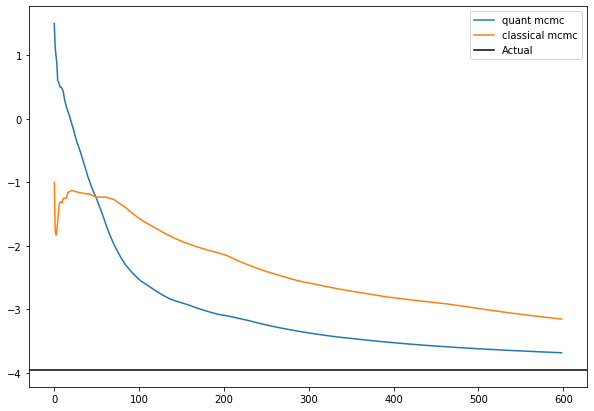

In [16]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops# 
#cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]
dict_for_df_running_avg_seperate_mcmc_q={}
for m in range(0, num_seperate_mcmc_chains):
  dict_for_df_running_avg_seperate_mcmc_q[m]=list(running_avg_magnetization(list_states_mcmc=dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]).values())

running_avg_q_df=pd.DataFrame(dict_for_df_running_avg_seperate_mcmc_q)
mean_magnetization_q=running_avg_q_df.mean(axis=1)# mean taken over all seperate mcmc chains

plt.figure(figsize=(10,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.plot(mean_magnetization_q,"-" ,label="quant mcmc")
plt.plot(mean_magnetization,"-" ,label="classical mcmc")
plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()

<Figure size 432x288 with 0 Axes>

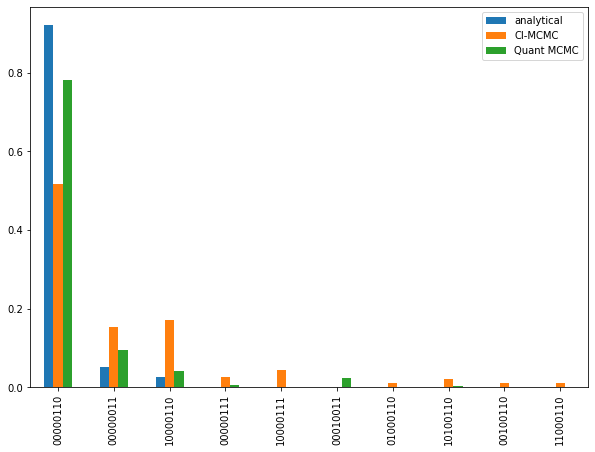

In [17]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_prob_distn_q=get_empirical_distn(dict_mean_occurences_q)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [18]:
print("KL divergence quantum case:");
print(kl_divergence(dict_empirical_prob_distn_q,boltz_prob_distn))
print("KL divergence classical case:")
print(kl_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn))

KL divergence quantum case:
0.2335946639384008
KL divergence classical case:
0.5250069654814651
